<a href="https://colab.research.google.com/github/Preetika764/SOP-Second-semester-2020-21/blob/main/Copy_of_generating_adversarial_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [ ]:
inceptionv3 = models.inception_v3(pretrained=True) #download and load pretrained inceptionv3 model
inceptionv3.eval();

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
url = 'https://s3.amazonaws.com/outcome-blog/wp-content/uploads/2017/02/25192225/cat.jpg' 
response = requests.get(url)
img = Image.open(io.BytesIO(response.content))

In [ ]:
#mean and std will remain same irresptive of the model you use
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((299,299)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

In [ ]:
image_tensor = preprocess(img) #preprocess an i
image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W

In [ ]:
img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable

In [ ]:
output = inceptionv3.forward(img_variable)
label_idx = torch.max(output.data, 1)[1][0]  #get an index(class number) of a largest element
print(label_idx)

tensor(285)


In [ ]:
labels_link = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels_json = requests.get(labels_link).json()
labels = {int(idx):label for idx, label in labels_json.items()}
x_pred = labels[label_idx.item()]
print(x_pred)

Egyptian cat


In [ ]:
y_true = 285   #tiger cat  ##change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)


tensor([285])


In [ ]:
#get probability dist over classes
output_probs = F.softmax(output, dim=1)
print(output_probs.size())
x_pred_prob = round((torch.max(output_probs.data, 1)[0][0].item() * 100),4)
print(x_pred_prob)

torch.Size([1, 1000])
70.1695


In [ ]:
y_true = 285   #tiger cat  ##change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

tensor([285])


In [ ]:
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)  

In [ ]:
output = inceptionv3.forward(img_variable)
print(output.size())
label_idx = torch.max(output.data, 1)[1][0]  #get an index(class number) of a largest element
print(label_idx)
labels_link = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels_json = requests.get(labels_link).json()
labels = {int(idx):label for idx, label in labels_json.items()}
x_pred = labels[label_idx.item()]
print(x_pred)

torch.Size([1, 1000])
tensor(285)


**FAST GRADIENT SIGN METHOD**

In [ ]:
eps = 0.02
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
output_adv = inceptionv3.forward(Variable(x_adversarial))   #perform a forward pass on adv example
label_adv_idx = torch.max(output_adv.data, 1)[1][0]  #get an index(class number) of a largest element
print(label_adv_idx)
x_adv_pred = labels[label_adv_idx.item()]
print(x_adv_pred)
op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
adv_pred_prob = round((torch.max(op_adv_probs.data, 1)[0][0].item() * 100),4)     #find probability (confidence) of a predicted class
print(adv_pred_prob)



tensor(281)
tabby, tabby cat
79.4797


In [ ]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

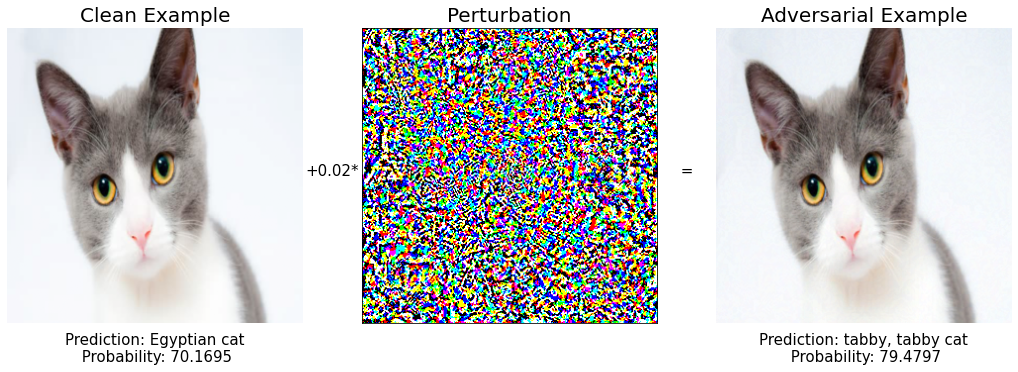

In [ ]:
visualize(image_tensor, x_adversarial, x_grad, eps, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

In [ ]:
epsilon = [0.00088, 0.004, 0.01, 0.12, 0.55]

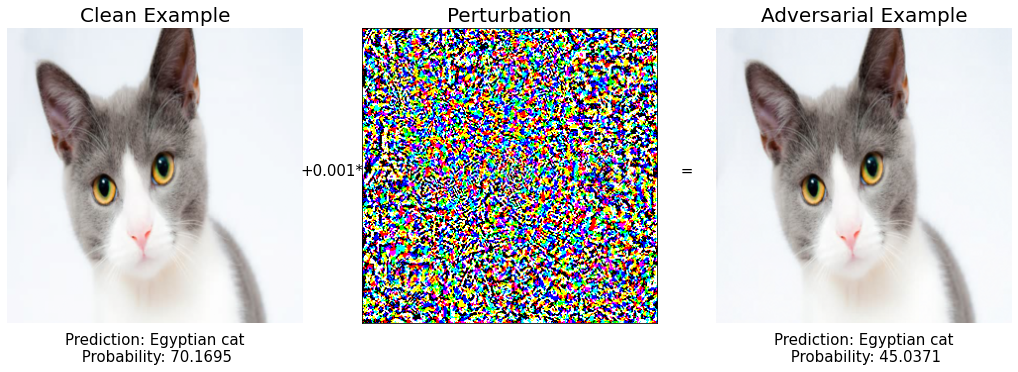

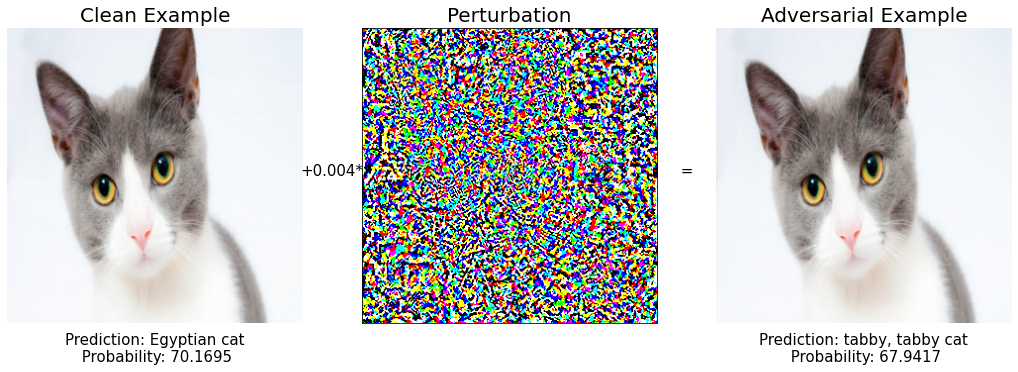

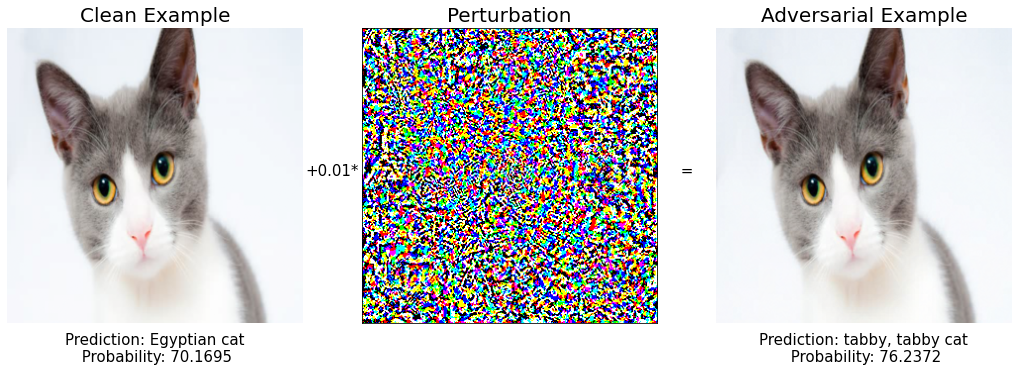

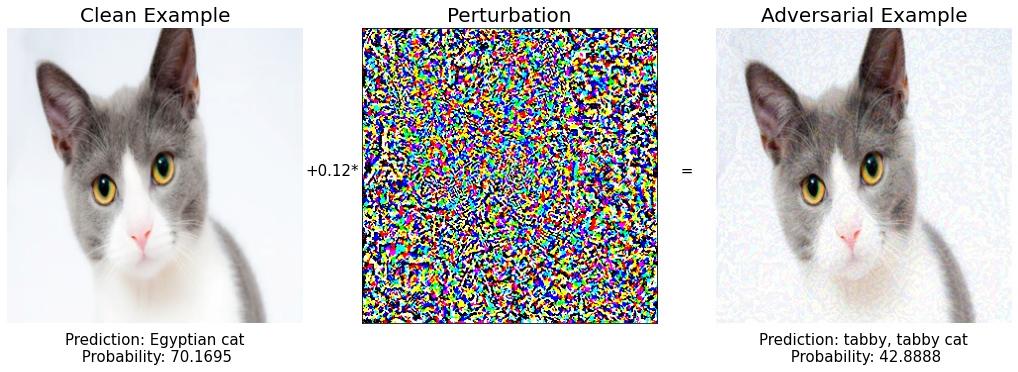

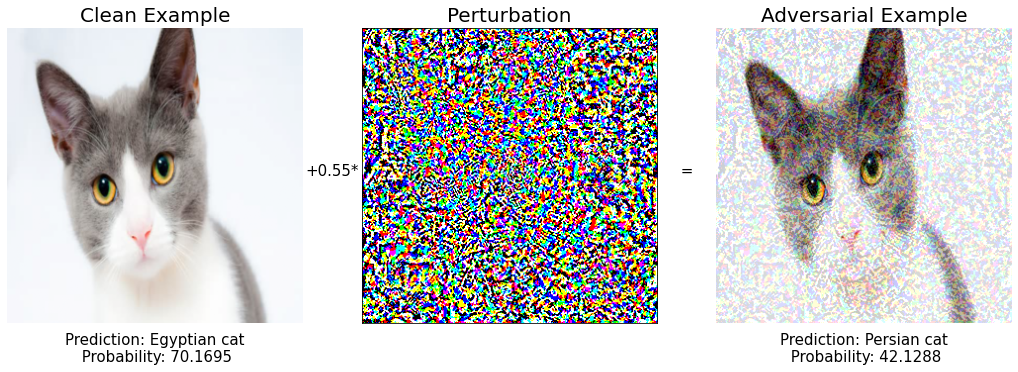

In [ ]:
x_grad = torch.sign(img_variable.grad.data)
for i in epsilon:
  x_adversarial = img_variable.data + i * x_grad
  output_adv = inceptionv3.forward(Variable(x_adversarial))
  x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0].item()]
  op_adv_probs = F.softmax(output_adv, dim=1)
  adv_pred_prob = round((torch.max(op_adv_probs.data, 1)[0][0].item() * 100),4) 
  visualize(image_tensor, x_adversarial, x_grad, i, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

In [ ]:
#targeted class can be a random class or the least likely class predicted by the network
y_target = 288   #leopard
y_target = Variable(torch.LongTensor([y_target]), requires_grad=False)
print(y_target)

tensor([288])


In [ ]:
zero_gradients(img_variable)                       #flush gradients
loss_cal2 = loss(output, y_target)
loss_cal2.backward()

In [ ]:
epsilons = [0.002, 0.01, 0.15, 0.5 ]

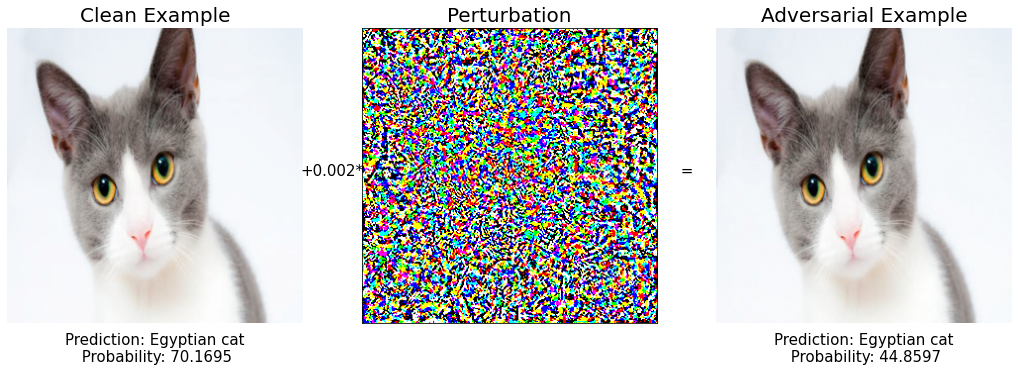

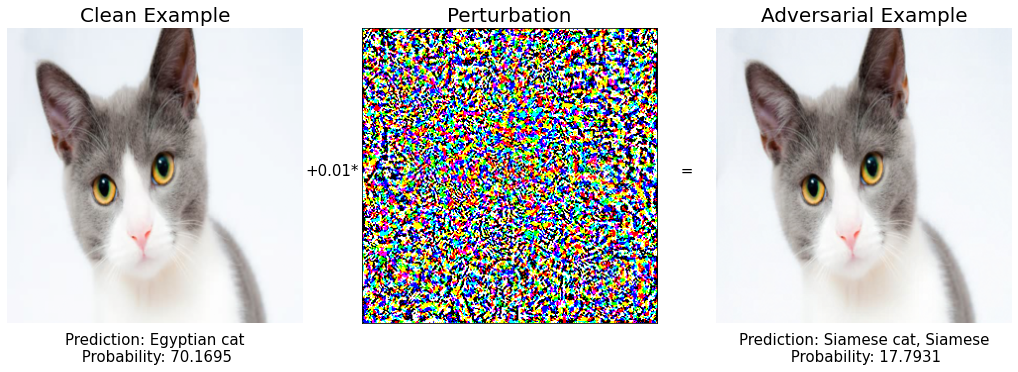

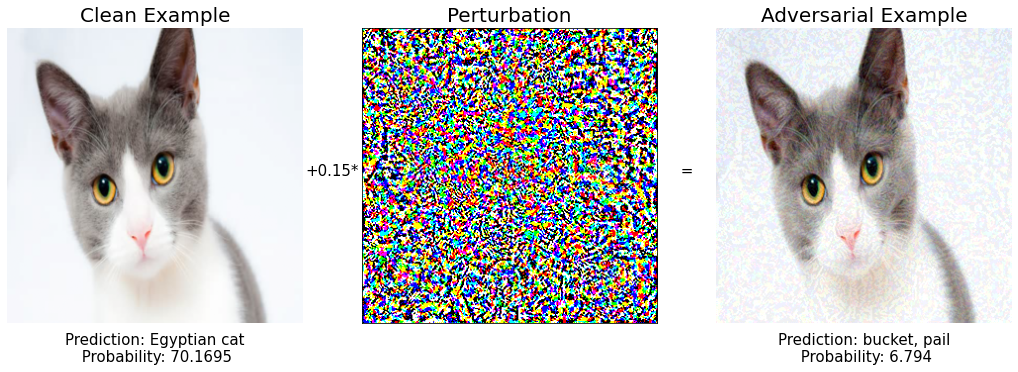

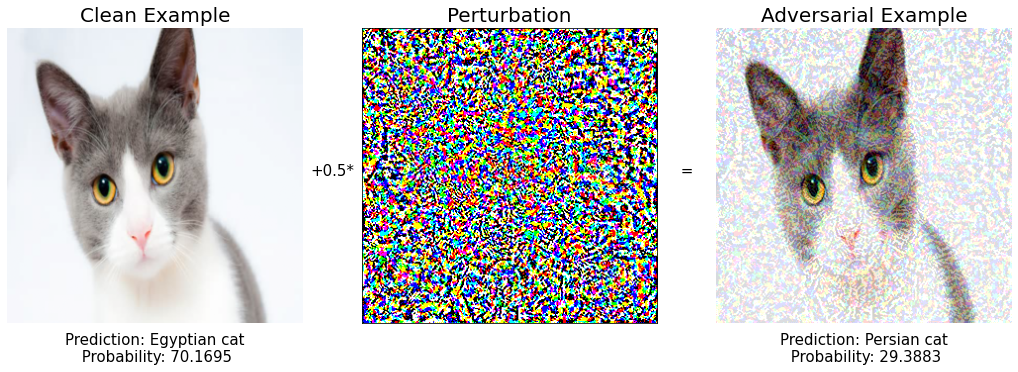

In [ ]:
x_grad = torch.sign(img_variable.grad.data)
for i in epsilons:
  x_adversarial = img_variable.data - i * x_grad
  output_adv = inceptionv3.forward(Variable(x_adversarial))
  x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0].item()]
  op_adv_probs = F.softmax(output_adv, dim=1)
  adv_pred_prob = round((torch.max(op_adv_probs.data, 1)[0][0].item() * 100),4)
  visualize(image_tensor, x_adversarial, x_grad, i, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

BASIC ITERATIVE METHOD

In [ ]:
y_true = Variable( torch.LongTensor([282]), requires_grad=False)   #tiger cat
epsilon = 0.25
num_steps = 5
alpha = 0.025
#above three are hyperparameters

In [ ]:
for i in range(num_steps):
  zero_gradients(img_variable)                       #flush gradients
  output = inceptionv3.forward(img_variable)         #perform forward pass
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, y_true)
  loss_cal.backward()
  x_grad = alpha * torch.sign(img_variable.grad.data)   # as per the formula
  adv_temp = img_variable.data + x_grad                 #add perturbation to img_variable which also contains perturbation from previous iterations
  total_grad = adv_temp - image_tensor                  #total perturbation
  total_grad = torch.clamp(total_grad, -epsilon, epsilon)
  x_adv = image_tensor + total_grad                      #add total perturbation to the original image
  img_variable.data = x_adv

#final adversarial example can be accessed at- img_variable.data

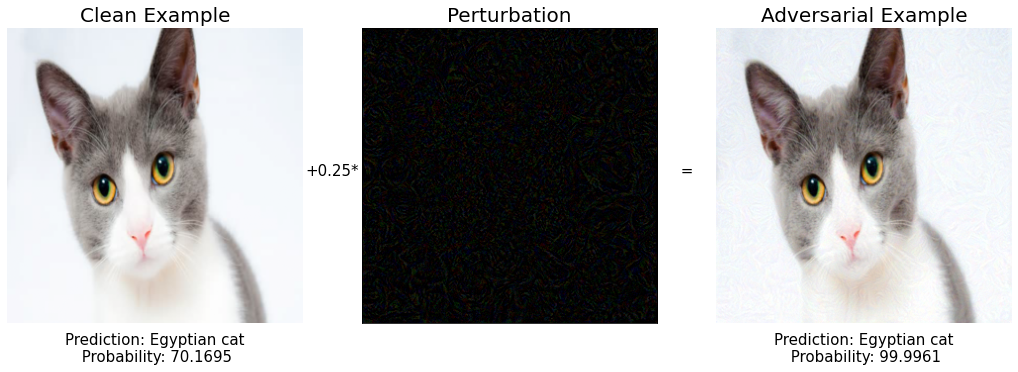

In [ ]:
output_adv = inceptionv3.forward(img_variable)
x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0].item()]  #classify adversarial example
output_adv_probs = F.softmax(output_adv, dim=1)
x_adv_pred_prob = round((torch.max(output_adv_probs.data, 1)[0][0].item() * 100),4)
visualize(image_tensor, img_variable.data, total_grad, epsilon, x_pred,x_adv_pred, x_pred_prob,  x_adv_pred_prob)  #class and prob of original ex will remain same

ITERATIVE TARGET CLASS METHOD

In [ ]:
y_target = Variable(torch.LongTensor([9]), requires_grad=False)    #9= ostrich
epsilon = 0.25
num_steps = 5
alpha = 0.025

In [ ]:
img_variable.data = image_tensor

In [ ]:
for i in range(num_steps):
  zero_gradients(img_variable)
  output = inceptionv3.forward(img_variable)
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, y_target)
  loss_cal.backward()
  x_grad = alpha * torch.sign(img_variable.grad.data)
  adv_temp = img_variable.data - x_grad
  total_grad = adv_temp - image_tensor
  total_grad = torch.clamp(total_grad, -epsilon, epsilon)
  x_adv = image_tensor + total_grad
  img_variable.data = x_adv

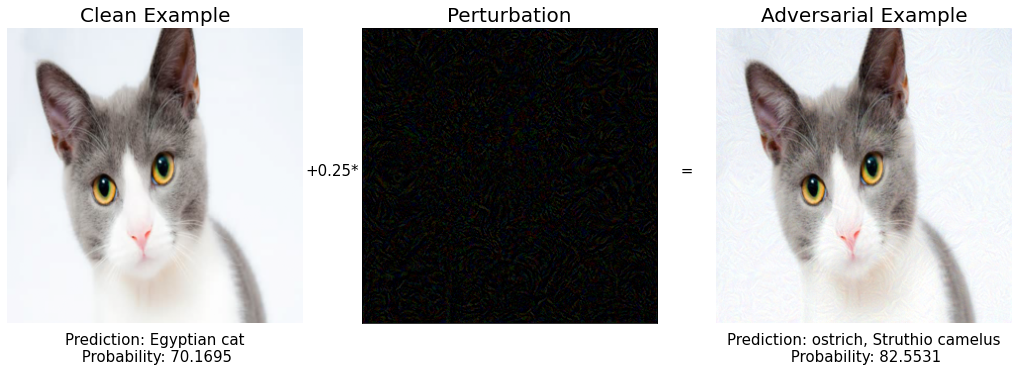

In [ ]:
output_adv = inceptionv3.forward(img_variable)
x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0].item()]
output_adv_probs = F.softmax(output_adv, dim=1)
x_adv_pred_prob = round((torch.max(output_adv_probs.data, 1)[0][0].item() * 100),4)
visualize(image_tensor, img_variable.data, total_grad, epsilon, x_pred,x_adv_pred, x_pred_prob,  x_adv_pred_prob)